In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing import image
import scipy
import os
import cv2

In [2]:
data = pd.read_csv('drive/MyDrive/data/fer2013.csv')

In [3]:
pixel_data = data['pixels']
label_data = data['emotion']

In [4]:
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
    images.append(img.astype('float32'))

  X = np.array(images)

  return X

In [5]:
X = preprocess_pixels(pixel_data)
print(X.shape)

(35887, 2304)


In [6]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_over,Y_over = smote.fit_resample(X, label_data)

In [7]:
def preprocess_imgs(X):
  faces = []
  for i in range(len(X)):
    face = X[i].reshape(48,48,1)
    faces.append(face)
  
  X = np.array(faces)

  return X

In [8]:
X = preprocess_imgs(X_over)
Y = Y_over
Y = Y_over.values.reshape(Y.shape[0],1)

print(X.shape)
print(Y.shape)

(62923, 48, 48, 1)
(62923, 1)


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size = 0.2, random_state=45)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=45)

In [10]:
X_aug = ImageDataGenerator(  
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1)
X_aug.fit(X_train)

In [11]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), strides=(1,1), padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.0005)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3), strides=(1,1), padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.0005)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), strides=(1,1), padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.0005)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), strides=(1,1), padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(0.0005)))
model.add(BatchNormalization(axis=3))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))

adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


model = Sequential()

# Conv Block 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv Block 2
model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected Block 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected Block 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       2

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit(Y_train)
Y_train = encoder.transform(Y_train).toarray()
Y_test = encoder.transform(Y_test).toarray()
Y_val =  encoder.transform(Y_val).toarray()

In [14]:
es = EarlyStopping(patience=60) 
mc = ModelCheckpoint("drive/MyDrive/model/emotion_weights.hdf5", monitor='val_loss', save_best_only=True) 
rlr = ReduceLROnPlateau(factor=0.1, patience=5)

In [15]:
history = model.fit(X_aug.flow(X_train, Y_train), epochs=100, validation_data=(X_val, Y_val), callbacks=[es, mc, rlr])

Epoch 1/100
1259/1259 [==============================] - 37s 27ms/step - loss: 2.0719 - accuracy: 0.2624 - val_loss: 1.7849 - val_accuracy: 0.3777 - lr: 1.0000e-04
Epoch 2/100
1259/1259 [==============================] - 36s 29ms/step - loss: 1.8374 - accuracy: 0.3559 - val_loss: 1.7056 - val_accuracy: 0.4227 - lr: 1.0000e-04
Epoch 3/100
1259/1259 [==============================] - 43s 34ms/step - loss: 1.7069 - accuracy: 0.4106 - val_loss: 1.5447 - val_accuracy: 0.4751 - lr: 1.0000e-04
Epoch 4/100
1259/1259 [==============================] - 37s 29ms/step - loss: 1.6105 - accuracy: 0.4472 - val_loss: 1.5977 - val_accuracy: 0.4556 - lr: 1.0000e-04
Epoch 5/100
1259/1259 [==============================] - 35s 28ms/step - loss: 1.5357 - accuracy: 0.4764 - val_loss: 1.4229 - val_accuracy: 0.5159 - lr: 1.0000e-04
Epoch 6/100
1259/1259 [==============================] - 35s 28ms/step - loss: 1.4816 - accuracy: 0.4939 - val_loss: 1.4238 - val_accuracy: 0.5164 - lr: 1.0000e-04
Epoch 7/100
1259

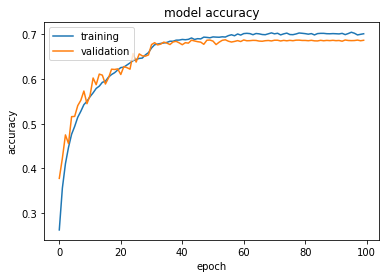

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [17]:
model.evaluate(X_test, Y_test)

394/394 [==============================] - 3s 8ms/step - loss: 0.9494 - accuracy: 0.6888


[0.9494085311889648, 0.6887564659118652]